(0.0, 1.0)

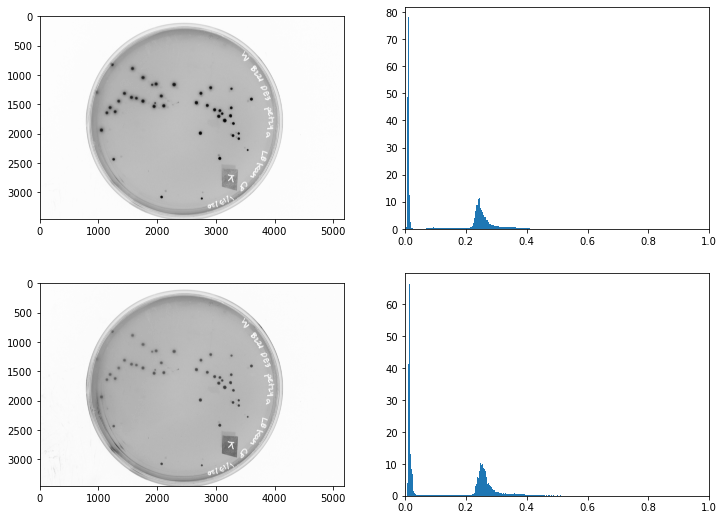

In [1]:
# These images are the work of Carla Perez (http://www.proteindesign.org/people.html)

# We'll use scikit-image, where images are simply NumPy arrays. We already know how to work with NumPy arrays!

from skimage import io as skiio
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

# We'll convert to grayscale as we import
wt_bright = skiio.imread("IMG_0049.JPG", as_gray = True)
wt_dark = skiio.imread("IMG_0050.JPG", as_gray = True)
f, axes = plt.subplots(2, 2, figsize = (12,9))
upperbound = np.max([wt_bright, wt_dark])
axes[0,0].imshow(wt_bright, cmap = 'binary', vmin = 0, vmax = upperbound)
axes[1,0].imshow(wt_dark, cmap = 'binary', vmin = 0, vmax = upperbound)
axes[0,1].hist(wt_bright.flatten(), density = True, bins = 256)
axes[1,1].hist(wt_dark.flatten(), density = True, bins = 256)
axes[0,1].set_xlim(0,1)
axes[1,1].set_xlim(0,1)

0.1393443144914216


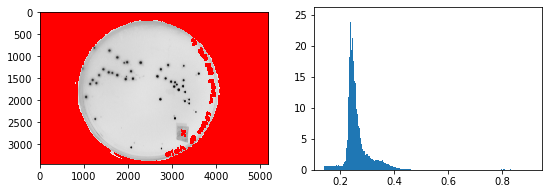

In [2]:
from skimage.filters import threshold_otsu

# Let's remove the background and handwriting. Otsu's method is a procedure for determining an optimal threshold
# by maximizing the sum of the variances 
threshold_wt_bright = threshold_otsu(wt_bright)
print(threshold_wt_bright)
#plt.imshow(wt_bright > threshold_wt_bright, cmap = 'binary')
#plt.colorbar()
wt_bright_masked_background = np.ma.masked_where(wt_bright < threshold_wt_bright, wt_bright)

cmap_badred = plt.get_cmap('binary')
cmap_badred.set_bad('red')

f, axes = plt.subplots(1, 2, figsize = (9,3))
axes[0].imshow(wt_bright_masked_background, cmap = cmap_badred)
_ = axes[1].hist(wt_bright_masked_background.compressed(), bins = 256, density = True)
# Note: matplotlib's hist() does not directly support masked arrays

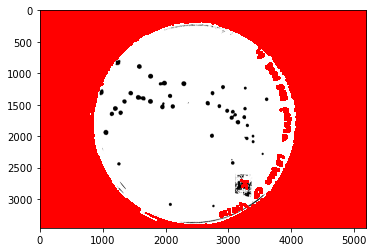

In [3]:
#It is clear from this histogram that the edges of the dish/tape are still a problem after removing the background
plt.imshow(wt_bright_masked_background > 0.4, cmap = 'binary')

# We will have to expand the masked region to exclude these edges
# Let's proceed with the bright image, which should be easier to segment, then use the same final mask on both
# bright and dark images

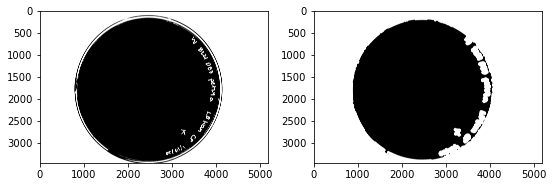

In [4]:
# We'll create a binary array containing the mask, then use binary erosion on it:
from skimage.morphology import erosion
from skimage.morphology import disk

mask_wt_keep = wt_bright > threshold_wt_bright
mask_wt_eroded = erosion(mask_wt_keep, disk(32))

f, axes= plt.subplots(1, 2, figsize = (9,3))
axes[0].imshow(mask_wt_keep, cmap = 'binary')
axes[1].imshow(mask_wt_eroded, cmap = 'binary')

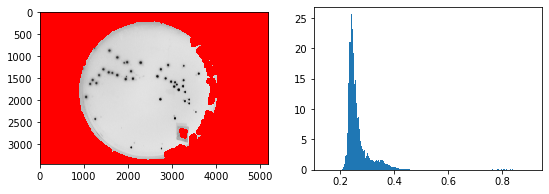

In [5]:
# Now let's re-mask our bright image and histogram:
wt_bright_masked_background = np.ma.masked_where(1 - mask_wt_eroded, wt_bright)

f, axes= plt.subplots(1, 2, figsize = (9,3))
axes[0].imshow(wt_bright_masked_background, cmap = cmap_badred)
_ = axes[1].hist(wt_bright_masked_background.compressed(), bins = 256, density = True)

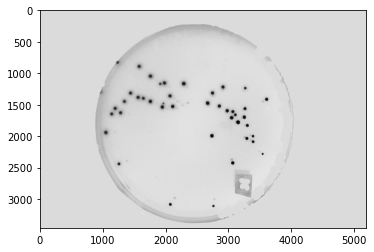

In [6]:
# The easiest way to see how well the edge effects are being removed is by filling the masked pixels with the
# median value, which should be close to the background shade
plt.imshow(np.ma.filled(wt_bright_masked_background, np.ma.median(wt_bright_masked_background)), cmap = 'binary')

42


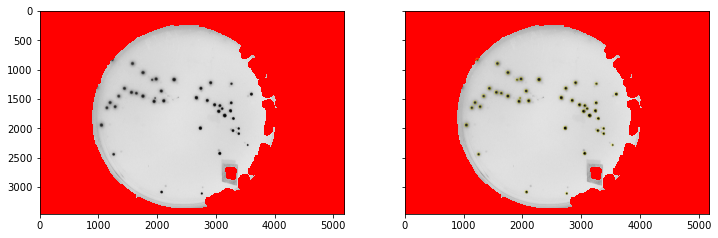

In [7]:
from skimage.feature import blob_log

blobs_log = blob_log(np.ma.filled(wt_bright_masked_background, np.ma.median(wt_bright_masked_background)),
                     min_sigma=2, max_sigma=25, num_sigma=100, threshold=0.15)
blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2)

print(len(blobs_log))

f, axes = plt.subplots(1,2, figsize = (12,6), sharey = True)
axes[0].imshow(wt_bright_masked_background, cmap = cmap_badred)
axes[1].imshow(wt_bright_masked_background, cmap = cmap_badred)
for blob in blobs_log:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='yellow', linewidth = 1, fill = False, alpha = 0.3)
    axes[1].add_patch(c)

f.savefig("fmntest.pdf")

In [8]:
# We could write a function to grab the mean intensity and number of pixels of each blob...
def quantify_all_blobs(blobs_log):
    blobs_means = np.empty(len(blobs_log)) # Note: we could make this work for trajectory data by using
    # np.empty((len(blobs_log), len(imagecollection)))
    blobs_areas = np.zeros(len(blobs_log))

    for i, blob in enumerate(blobs_log):
        y, x, r = blob
        trajsum = 0 # and using np.zeros(len(imagecollection)) here
        # The naive (slow) method would be to iterate over all pixels instead of only those unmasked:
        # for ypix in range(wt_bright.shape[0]):
        #     for xpix in range(wt_bright.shape[1]):
        #         if mask_wt_eroded[ypix, xpix] == 1:
        for ypix, xpix in np.transpose(np.nonzero(mask_wt_eroded == 1)):
            if (ypix - y) ** 2 + (xpix - x) ** 2 <= r ** 2:
                blobs_areas[i] += 1
                trajsum += wt_bright[ypix, xpix] # and replacing this indexing with [:, ypix, xpix]
        blobs_means[i] = trajsum / blobs_areas[i]
    
    return blobs_means, blobs_areas
    # We could also make the above a lot faster by writing a float-accepting version of skimage's disk()

In [9]:
# But instead of using quantify_all_blobs, which takes quite a while, we'll take advantage of how trivially
# parallel this task is
from multiprocessing import Pool

# We'll define a function that we want applied to all of our blobs
def quantify_blob(blob):
    y, x, r = blob
    area = 0
    trajsum = 0
    for ypix, xpix in np.transpose(np.nonzero(mask_wt_eroded == 1)):
        if (ypix - y) ** 2 + (xpix - x) ** 2 <= r ** 2:
            area += 1
            trajsum += wt_bright[ypix, xpix]
    return trajsum / area, area

# And apply this function to every element of the list of blobs using a pool of 10 processors
with Pool(10) as p:
    blobs_means, blobs_areas = zip(*p.map(quantify_blob, blobs_log)) # Map  gives a tuple (mean, area) for each...
# Note: multiprocessing spawns processes that each have a copy of everything in memory, which speeds up our case,
# but can also quickly fill memory if you aren't careful. It is usually a good idea to test the memory usage with
# a few processes first.

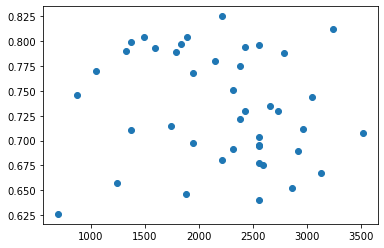

In [10]:
# Let's make sure that there's no relationship between the mean and area:
plt.scatter(blobs_areas, blobs_means)
# Now we should be confident that clipped blobs are okay to include, as we explicitly use the area within the mask

In [14]:
# We'll redefine quantify_blob to work on arbitrary frames with arbitrary masks:
def quantify_blob(blob, frame, mask):
    y, x, r = blob
    area = 0
    trajsum = 0
    for ypix, xpix in np.transpose(np.nonzero(mask == 1)):
        if (ypix - y) ** 2 + (xpix - x) ** 2 <= r ** 2:
            area += 1
            trajsum += frame[ypix, xpix]
    return trajsum / area, area


# Let's define a function to take a paired bright and dark frame and do the same analysis on the bright frame,
# and apply the same resulting mask to the dark frame:
def analyze_pair(bright_frame, dark_frame, nproc):
    threshold = threshold_otsu(bright_frame)
    mask_keep = bright_frame > threshold
    mask_eroded = erosion(mask_keep, disk(32))
    bright_masked_background = np.ma.masked_where(1 - mask_eroded, bright_frame)
    blobs_log = blob_log(np.ma.filled(bright_masked_background, np.ma.median(bright_masked_background)),
                         min_sigma=2, max_sigma=25, num_sigma=100, threshold=0.15)
    blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2)
    frame = bright_frame
    with Pool(nproc) as p:
        bright_blobs_means, blobs_areas = zip(*p.starmap(quantify_blob,
                                                         [(blob, bright_frame, mask_eroded) for blob in blobs_log]))
    with Pool(nproc) as p:
        dark_blobs_means, _ = zip(*p.starmap(quantify_blob,
                                             [(blob, dark_frame, mask_eroded) for blob in blobs_log]))
    return bright_blobs_means, dark_blobs_means, blobs_areas

In [15]:
# Let's apply this function to the wild-type images:
wt_bright_means, wt_dark_means, wt_areas = analyze_pair(wt_bright, wt_dark, 10)

(array([4., 2., 9., 5., 4., 2., 3., 5., 6., 2.]),
 array([0.43605364, 0.45517279, 0.47429193, 0.49341107, 0.51253021,
        0.53164936, 0.5507685 , 0.56988764, 0.58900678, 0.60812593,
        0.62724507]),
 <a list of 10 Patch objects>)

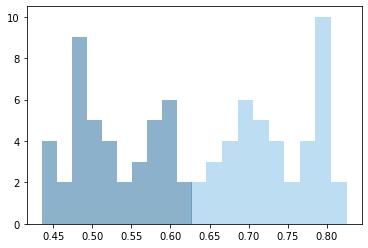

In [20]:
# Histogram the bright and dark means:
plt.hist(wt_bright_means, color = "#7cbce9", alpha = 0.5)
plt.hist(wt_dark_means, color = "#1a6499", alpha = 0.5)

Text(0.5, 1.0, 'Wild-type colonies')

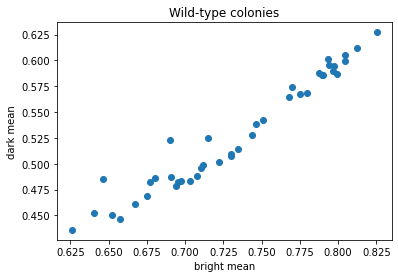

In [33]:
plt.scatter(wt_bright_means, wt_dark_means)
plt.xlabel("bright mean")
plt.ylabel("dark mean")
plt.title("Wild-type colonies")

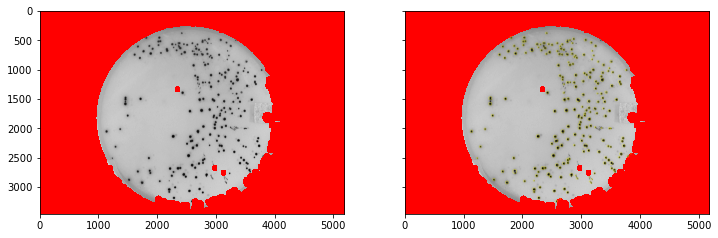

In [31]:
# We'll load a circular permutant image pair and make sure the same threshold is appropriate:
circperm3_bright = skiio.imread("IMG_0052.JPG", as_gray = True)
circperm3_dark = skiio.imread("IMG_0053.JPG", as_gray = True)

threshold = threshold_otsu(circperm3_bright)
mask_keep = circperm3_bright > threshold
mask_eroded = erosion(mask_keep, disk(32))
bright_masked_background = np.ma.masked_where(1 - mask_eroded, circperm3_bright)
blobs_log = blob_log(np.ma.filled(bright_masked_background, np.ma.median(bright_masked_background)),
                     min_sigma=2, max_sigma=25, num_sigma=100, threshold=0.15)
blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2)

f, axes = plt.subplots(1,2, figsize = (12,6), sharey = True)
axes[0].imshow(bright_masked_background, cmap = cmap_badred)
axes[1].imshow(bright_masked_background, cmap = cmap_badred)
for blob in blobs_log:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='yellow', linewidth = 1, fill = False, alpha = 0.3)
    axes[1].add_patch(c)

f.savefig("fmntest.pdf")

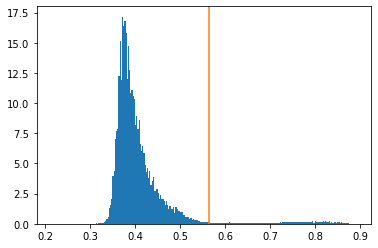

In [36]:
_ = plt.hist(bright_masked_background.compressed(), bins = 256, density = True)
plt.axvline(threshold_otsu(bright_masked_background.compressed()), color = 'C1')

# We can see that the background distribution is different - and brighter - than the wild-type
# This is likely due to the plate thickness and concentration

# While we could use another Otsu threshold (shown as orange line) to adjust for the background amount and
# segment based on a simple threshold, we see the power in the Laplacian of Gaussian method, which is insensitive
# to background level, for detecting circular objects

In [26]:
# Now we'll apply the same function to the circular permutant:
circperm3_bright_means, circperm3_dark_means, circperm3_areas = analyze_pair(circperm3_bright, circperm3_dark, 10)

(array([ 2.,  0.,  5.,  7., 18., 33., 34., 40., 56., 13.]),
 array([0.45550946, 0.47440924, 0.49330902, 0.51220881, 0.53110859,
        0.55000837, 0.56890815, 0.58780793, 0.60670771, 0.62560749,
        0.64450727]),
 <a list of 10 Patch objects>)

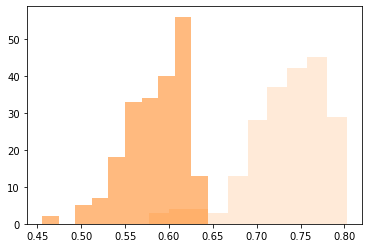

In [29]:
plt.hist(circperm3_bright_means, color = "#ffd6b3", alpha = 0.5)
plt.hist(circperm3_dark_means, color = "#ff7700", alpha = 0.5)

Text(0.5, 1.0, 'Circular permutant 3 colonies')

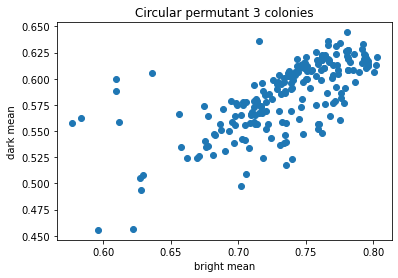

In [32]:
plt.scatter(circperm3_bright_means, circperm3_dark_means)
plt.xlabel("bright mean")
plt.ylabel("dark mean")
plt.title("Circular permutant 3 colonies")